В этом соревновании вам нужно предсказать популярность объявления о продаже домов в Нью-Йорке, основываясь на текстовом описании, локации, количестве спален, цене etc.

Вы решаете задачу классификации: нужно предсказать TARGET − low, medium или high. Метрка − точность.

train.csv − датасет для обучения (38 тысяч примеров, 12 фичей + лейбл)
test.csv − датасет для оценивания решений (11 тысяч примеров, 12 фичей)

Фичи:

* bathrooms: количество ванных
* bedrooms: количество спален
* building_id: ID здания
* created: дата создания объявления
* display_address: адрес (текстом)
* features: список разных полезных текстовых тегов
* latitude: ширина (координата)
* longitude: долгода (координата)
* listing_id: ID объявления
* manager_id: ID риелтора
* photos: количество фотографий у объявления
* price: цена в долларах
* TARGET: целевая переменная; "low", "medium" или "high"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

X = pd.read_csv('/content/drive/MyDrive/train.csv',delimiter=',')
X_test = pd.read_csv('/content/drive/MyDrive/test.csv',delimiter=',')

In [ ]:
X.head()

,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,TARGET
0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,7039994,-73.9918,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium
1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,7166774,-74.0322,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium
2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,6962716,-73.9751,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low
3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,7002458,-74.0065,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low
4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,7170465,-74.0025,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34546 entries, 0 to 34545
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               34546 non-null  int64  
 1   bathrooms        34546 non-null  float64
 2   bedrooms         34546 non-null  int64  
 3   building_id      34546 non-null  object 
 4   created          34546 non-null  object 
 5   description      33509 non-null  object 
 6   display_address  34458 non-null  object 
 7   features         34546 non-null  object 
 8   latitude         34546 non-null  float64
 9   listing_id       34546 non-null  int64  
 10  longitude        34546 non-null  float64
 11  manager_id       34546 non-null  object 
 12  photos           34546 non-null  object 
 13  price            34546 non-null  int64  
 14  street_address   34542 non-null  object 
 15  TARGET           34546 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 4.2+ MB


# Data preprocessing and Feature engineering

**Получим новые признаки по широте и долготе каждого объявления**
* city - город
* state - штат
* neighbourhood - окрестность
* suburb - район
* postcode - почтовый индекс

In [ ]:
pip install geopy

In [ ]:
from geopy.geocoders import Nominatim

# initialize Nominatim API 
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
data = X.copy()

In [ ]:
from tqdm import tqdm

for i in tqdm(range(data.shape[0])):
  lat = data.iloc[i]['latitude']
  lon = data.iloc[i]['longitude']
  location = geolocator.reverse(str(lat) + "," + str(lon))
  address = location.raw['address']
  city = address.get('city', '')
  state = address.get('state', '')
  neighbourhood = address.get('neighbourhood', '')
  suburb = address.get('suburb', '')
  postcode = address.get('postcode', '')
  data.loc[ i ,'city'] = city
  data.loc[ i ,'state'] = state
  data.loc[ i ,'neighbourhood'] = neighbourhood
  data.loc[ i ,'suburb'] = suburb
  data.loc[ i ,'postcode'] = postcode

100%|██████████| 34546/34546 [4:47:55<00:00,  2.00it/s]


In [ ]:
from google.colab import files

data.to_csv('train_new.csv') 
files.download("train_new.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Посмотрим на новые признаки

In [4]:
X = pd.read_csv('/content/drive/MyDrive/train_new.csv', delimiter=',')
X.head()

,Unnamed: 0,Id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,...,manager_id,photos,price,street_address,TARGET,city,state,neighbourhood,suburb,postcode
0,0,57094,1.0,3,0,2016-05-19 18:06:27,A FABULOUS 3BR IN MIDTOWN WEST! PERFECT APAR...,HOW AMAZING IS THIS MIDTOWN WEST STEAL!! NO FE...,"['Laundry In Unit', 'No Fee', 'Elevator']",40.7647,...,4bdc3d8c1aaa90d997ce2cb77680679b,['https://photos.renthop.com/2/7039994_07be01b...,4495,W 50 & AVE 10,medium,New York,New York,Theater District,NaN,10019
1,1,33389,1.0,1,9225efdfb57a50bf3ec17ebab082f94a,2016-06-16 02:01:49,Renovated Kitchen and Bathroom!,55 River Drive South,"['Dogs Allowed', 'Cats Allowed', 'No Fee']",40.7275,...,e5808a5e6cc13988fe596704428d38d5,['https://photos.renthop.com/2/7166774_03cf63a...,2570,55 River Drive South,medium,Jersey City,New Jersey,Newport,NaN,07310
2,2,60458,1.0,0,320de7d3cc88e50a7fbbcfde1e825d21,2016-05-04 02:42:50,RARE AND BEST DEAL ON THE MARKET!!!! PERFECT S...,W 77 Street,"['Elevator', 'Hardwood Floors']",40.7798,...,d69d4e111612dd12ef864031c1148543,['https://photos.renthop.com/2/6962716_ec7f56f...,1795,22 W 77 Street,low,New York,New York,NaN,Manhattan,10023
3,3,53048,1.0,2,ce6d18bf3238e668b2bf23f4110b7b67,2016-05-12 05:57:56,Newly renovated flex 2 apartment offers the ne...,John Street,"['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...",40.7081,...,e6472c7237327dd3903b3d6f6a94515a,['https://photos.renthop.com/2/7002458_93f4010...,3400,100 John Street,low,New York,New York,Financial District,NaN,10038
4,4,592,1.0,3,fee4d465932160318364d9d48d272879,2016-06-16 06:06:15,LOW FEE apartments do not come around like thi...,West 16th Street,"['Laundry in Building', 'Laundry in Unit', 'Di...",40.7416,...,6fba9b3a8327c607b8b043716efee684,['https://photos.renthop.com/2/7170465_9c3f173...,5695,321 West 16th Street,low,New York,New York,Chelsea District,NaN,10011


In [5]:
X.isna().sum()

Unnamed: 0             0
Id                     0
bathrooms              0
bedrooms               0
building_id            0
created                0
description         1037
display_address       88
features               0
latitude               0
listing_id             0
longitude              0
manager_id             0
photos                 0
price                  0
street_address         4
TARGET                 0
city                  90
state                  8
neighbourhood       6692
suburb             26133
postcode              12
dtype: int64

Получилось, что колонки suburb и neighbourhood имеют слишком много пропущенных значений, в дальнейшем их удалим, хотя на них было больше всего надежды, так как они могли бы пригодиться

In [6]:
from collections import Counter

Counter(X['city'])

Counter({'Boston': 4,
         'Braintree': 2,
         'East Whiteland Township': 1,
         'Jersey City': 14,
         'Moonachie': 1,
         'Needham': 1,
         'New York': 34426,
         'Newark': 1,
         'Quincy': 1,
         'Stamford': 3,
         'Yonkers': 2,
         nan: 90})

In [7]:
Counter(X['state'])

Counter({'Connecticut': 3,
         'Massachusetts': 8,
         'New Jersey': 46,
         'New York': 34480,
         'Pennsylvania': 1,
         nan: 8})

In [8]:
Counter(X['neighbourhood'])

Counter({'Alphabet City': 61,
         'Astoria': 1,
         'Bath Beach': 5,
         'Battery Park City': 247,
         'Bloomingdale': 23,
         'Boerum Hill': 15,
         'Brighton Beach': 2,
         'Brooklyn Community District 17': 11,
         'Brooklyn Heights': 116,
         'Carnegie Hill': 831,
         'Carroll Gardens Historic District': 1,
         'Chelsea': 298,
         'Chelsea District': 723,
         'Chinatown': 4,
         'Civic Center': 1,
         'Cobble Hill Historic District': 39,
         'Colgate Center': 1,
         'Concord': 1,
         'Coney Island': 1,
         'Country Club': 1,
         'Ditmas Park': 5,
         'Downtown Brooklyn': 103,
         'Downtown Jersey City': 3,
         'Dyker Heights': 12,
         'East Flatbush': 8,
         'East Harlem': 728,
         'East Village': 1953,
         'Eastern Parkway': 1,
         'Fieldston': 8,
         'Financial District': 2351,
         'Five Points': 1,
         'Flatiron District': 27,


In [9]:
Counter(X['suburb'])

Counter({'Back Bay': 4,
         'Brooklyn': 2530,
         'Kings County': 653,
         'Manhattan': 3552,
         'Needham Heights': 1,
         'Queens': 1179,
         'Queens County': 256,
         'Richmond County': 1,
         'Staten Island': 8,
         'The Bronx': 229,
         nan: 26133})

In [10]:
print(len(X['Id'].value_counts()))
print(len(X['listing_id'].value_counts()))

34546
34546


* Удалим объявления у которых широта и долгота равны 0, так как это похоже на выбросы
* Удалим объявления у которых не удалось определить город или почтовый индекс, так как, скорее всего, их широта и долгота заданы некорректно (либо по указанной широте и долготе нет конкретного дома, или их несколько и т.д.), а значит это может помешать обучению нашей модели 
* Удалим признаки description, display_address, street_address, state, neighbourhood и suburb, так как они имеют много пропущенных значений и вряд ли нам помогут
* удалим признак city, так там почти все города New York
* удалим признаки Id и listing_id, так как там все значения уникальные
* удалим признак manager_id так как он вряд ли нам поможет

In [11]:
X = X.loc[(X['latitude'] != 0) & (X['longitude'] != 0)]

X = X.dropna(axis='index', how='any', subset=['city'])
X = X.dropna(axis='index', how='any', subset=['postcode'])

X = X.drop(columns=['Unnamed: 0', 'description', 'display_address', 'street_address', 'Id', 'listing_id', 'manager_id', 'city', 'state', 'neighbourhood', 'suburb'])

Удалим аналогичные признаки в X_test

In [12]:
X_test = X_test.drop(columns=['description', 'display_address', 'street_address', 'listing_id', 'manager_id'])

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34452 entries, 0 to 34545
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    34452 non-null  float64
 1   bedrooms     34452 non-null  int64  
 2   building_id  34452 non-null  object 
 3   created      34452 non-null  object 
 4   features     34452 non-null  object 
 5   latitude     34452 non-null  float64
 6   longitude    34452 non-null  float64
 7   photos       34452 non-null  object 
 8   price        34452 non-null  int64  
 9   TARGET       34452 non-null  object 
 10  postcode     34452 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 3.2+ MB


postcode оказывается object, преобразуем в float

In [14]:
def change_postcode(data):
  for i in range(data.shape[0]):
    postcode = data.iloc[i]['postcode']
    
    if postcode.find('-') > 0:
      data.loc[ i ,'postcode'] = postcode[:5]
    elif postcode.find(':') > 0:
      data.loc[ i ,'postcode'] = postcode[:5]

In [15]:
X = X.reset_index(drop=True)

In [16]:
change_postcode(X)

In [17]:
X['postcode'] = X['postcode'].astype(float)

Cоздадим диаграмму рассеяния с широтой и долготой для визуализации данных

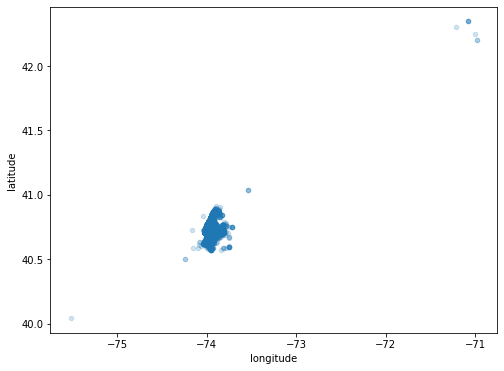

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
X.plot(kind = "scatter", x ="longitude", y ="latitude", alpha = 0.2)

Видим, что у нас всё ещё есть выбросы - уберём их

In [19]:
X = X.loc[(X['latitude'] < 42.0) & (X['longitude'] < -72)]
X = X.loc[(X['latitude'] > 40.2) & (X['longitude'] > -75)]

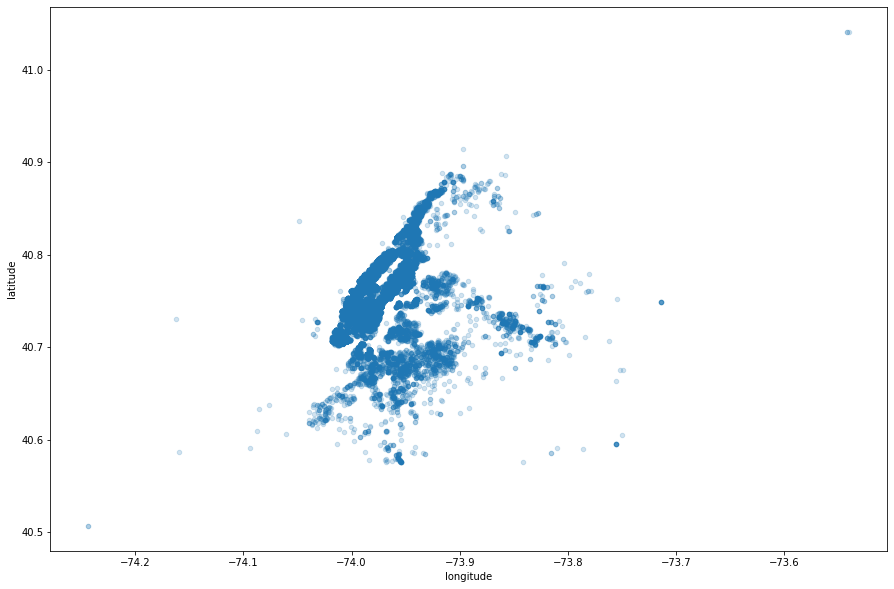

In [20]:
plt.rcParams["figure.figsize"] = (15, 10)
X.plot(kind = "scatter", x ="longitude", y ="latitude", alpha = 0.2)

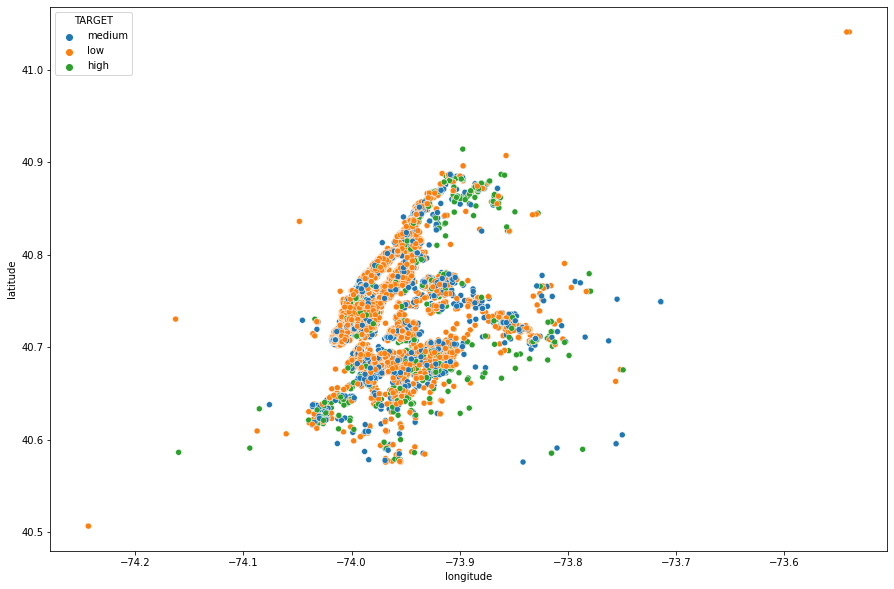

In [21]:
import seaborn as sns

sns.scatterplot(x="longitude", y="latitude", hue="TARGET", data=X);

Выглядит так, как будто больше всего объявлений с низкой популярностью расположены на северо-западе (недалеко от Jersey City)

**Достанем из признака features полезные слова и сделаем из них новые признаки**

In [22]:
features = []

for i in range(X.shape[0]):
   feat = X.iloc[i]['features']
   if feat.find(' * ') > 0:
     feat = feat[2:-2].split(" * ")
   else:
     feat = feat[2:-2].split("', '")
   features.extend(feat)

features = [x.lower() for x in features]

Вот какие признаки мы сделаем:
* no/reduced_fee - без платы агентству за оказание услуги, сниженная плата
* elevator - наличие лифта
* pets - разрешены ли животные
* laundry - наличие прачечной
* hardwood_floors - паркетные полы
* doorman - наличие консьержа/швейцара/домофона
* furniture - наличие какой-либо мебели/техники
* pre-war_building - довоенное ли здание
* sport - наличие рядом спортивных организаций/площадок
* park/terrace/garden - наличие балкона/сада/парка
* internet - наличие интернета
* parking - наличие парковки
* nice_view - отличный вид
* repair - наличие ремонта
* subway - наличие метро рядом

In [23]:
from tqdm import tqdm

def adding_new_feats(data):
  for i in tqdm(range(data.shape[0])):
    feat = data.iloc[i]['features']
    feat = feat.lower()

    if feat.find('fee') >= 0 and feat.find('additional fee') < 0: #fee
      data.loc[ i ,'no/reduced_fee'] = 1
    else:
      data.loc[ i ,'no/reduced_fee'] = 0


    if feat.find('elevator') >= 0 or feat.find('elev') >= 0: #elevator
      data.loc[ i ,'elevator'] = 1
    else:
      data.loc[ i ,'elevator'] = 0


    if (feat.find('pets') >= 0 and feat.find('no pets') < 0) or \
        feat.find('cats') >= 0 or feat.find('dog') >= 0 or feat.find('animal') >=0 : #pets
      data.loc[ i ,'pets'] = 1
    else:
      data.loc[ i ,'pets'] = 0


    if feat.find('laundry') >= 0: #laundry
      data.loc[ i ,'laundry'] = 1
    else:
      data.loc[ i ,'laundry'] = 0


    if (feat.find('wood') >= 0 and feat.find('fireplace') < 0) or \
       (feat.find('oak') >= 0 and feat.find('soaking') < 0): #hardwood_floors
      data.loc[ i ,'hardwood_floors'] = 1
    else:
      data.loc[ i ,'hardwood_floors'] = 0


    if feat.find('concierge') >= 0 or feat.find('doorman') >= 0 or feat.find('intercom') >= 0: 
      data.loc[ i ,'doorman'] = 1 #doorman
    else:
      data.loc[ i ,'doorman'] = 0


    if feat.find('furnished') >= 0 or \
       feat.find('tv') >= 0 or feat.find('conditioning') >= 0 or \
       feat.find('microwave') >= 0 or feat.find('dryer') >= 0 or \
       feat.find('washer') >= 0 or feat.find('dishwasher') >= 0 or \
       feat.find('fireplace') >= 0: 
      data.loc[ i ,'furniture'] = 1 #furniture
    else:
      data.loc[ i ,'furniture'] = 0


    if feat.find('pre-war') >= 0 or feat.find('prewar') >= 0: #pre-war building
      data.loc[ i ,'pre-war_building'] = 1
    else:
      data.loc[ i ,'pre-war_building'] = 0


    if feat.find('fitness') >= 0 or feat.find('gym') >= 0 or \
       feat.find('pool') >= 0 or feat.find('court') >= 0  or \
       feat.find('basketball') >= 0  or feat.find('yoga') >= 0  or \
       feat.find('pilates') >= 0 or feat.find('dance') >= 0: 
      data.loc[ i ,'sport'] = 1 #sport
    else:
      data.loc[ i ,'sport'] = 0


    if (feat.find('park') >= 0 and feat.find('parking') < 0) or \
       feat.find('balcon') >= 0 or feat.find('terrace') >= 0 or \
       feat.find('garden') >= 0 or feat.find('patio') >= 0  or \
       feat.find('yard') >= 0 or \
       (feat.find('roof') >= 0 and feat.find('proof') < 0):
      data.loc[ i ,'park/terrace/garden'] = 1 #park/terrace/garden
    else:
      data.loc[ i ,'park/terrace/garden'] = 0


    if feat.find('internet') >= 0 or feat.find('wifi') >= 0 or feat.find('wi-fi') >= 0:
      data.loc[ i ,'internet'] = 1 #internet
    else:
      data.loc[ i ,'internet'] = 0


    if feat.find('garage') >= 0 or feat.find('parking') >= 0: #parking
      data.loc[ i ,'parking'] = 1 
    else:
      data.loc[ i ,'parking'] = 0


    if feat.find('view') >= 0: #nice view
      data.loc[ i ,'nice_view'] = 1
    else:
      data.loc[ i ,'nice_view'] = 0


    if feat.find('renovat') >= 0: #repair
      data.loc[ i ,'repair'] = 1
    else:
      data.loc[ i ,'repair'] = 0


    if feat.find('subway') >= 0 or \
       (feat.find('train') >= 0 and feat.find('training') < 0) or\
       feat.find('stop') >= 0 or feat.find('bedford') >= 0:   #bedford - название остановки
      data.loc[ i ,'subway'] = 1  #subway
    else:
      data.loc[ i ,'subway'] = 0

In [24]:
X = X.reset_index(drop=True)

Добавим признаки в тренировочную и тестовую выборки

In [25]:
adding_new_feats(X)
adding_new_feats(X_test)

100%|██████████| 14806/14806 [01:05<00:00, 225.40it/s]


In [26]:
X.isna().sum()

bathrooms              0
bedrooms               0
building_id            0
created                0
features               0
latitude               0
longitude              0
photos                 0
price                  0
TARGET                 0
postcode               0
no/reduced_fee         0
elevator               0
pets                   0
laundry                0
hardwood_floors        0
doorman                0
furniture              0
pre-war_building       0
sport                  0
park/terrace/garden    0
internet               0
parking                0
nice_view              0
repair                 0
subway                 0
dtype: int64

Удалим ненужные признаки, так как почти все значения в них = 0

Удалим ставший ненужным features

In [27]:
print(Counter(X['parking']))
print(Counter(X['nice_view']))
print(Counter(X['repair']))
print(Counter(X['subway']))

Counter({0.0: 33400, 1.0: 1043})
Counter({0.0: 34379, 1.0: 64})
Counter({0.0: 34064, 1.0: 379})
Counter({0.0: 34326, 1.0: 117})


In [28]:
X = X.drop(columns=['features', 'parking', 'nice_view', 'repair', 'subway'])
X_test = X_test.drop(columns=['features', 'parking', 'nice_view', 'repair', 'subway'])

**Добавим признак - стоимость одной комнаты**

In [29]:
Counter(X['bedrooms'] + X['bathrooms'])

Counter({0.0: 104,
         1.0: 6557,
         1.5: 8,
         2.0: 10710,
         2.5: 116,
         3.0: 7756,
         3.5: 160,
         4.0: 4834,
         4.5: 211,
         5.0: 2215,
         5.5: 155,
         6.0: 1137,
         6.5: 61,
         7.0: 210,
         7.5: 26,
         8.0: 87,
         8.5: 17,
         9.0: 54,
         9.5: 6,
         10.0: 13,
         10.5: 2,
         11.0: 3,
         12.0: 1})

Получилось, что в 102 квартирах нет ни одной спальни и ванной комнаты, такого быть не может, поэтому в расчётах будем считать, что там есть одна комната

In [30]:
def adding_cost_of_one_room(data):
  for i in range(data.shape[0]):
    rooms = np.sum(data.iloc[i]['bedrooms'] + data.iloc[i]['bathrooms'])

    if rooms == 0:
      data.loc[ i ,'cost_of_one_room'] = data.iloc[i]['price'] #cчитаем, что есть одна комната
    else:
      data.loc[ i ,'cost_of_one_room'] = data.iloc[i]['price'] / rooms

In [31]:
adding_cost_of_one_room(X)
adding_cost_of_one_room(X_test)

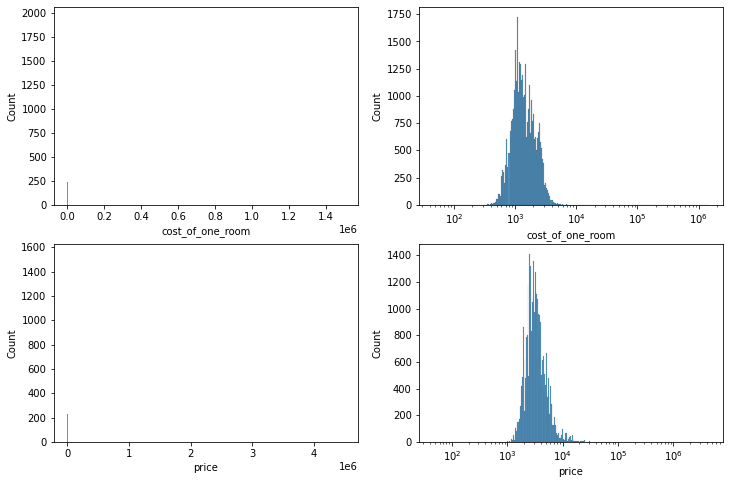

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=X, x="cost_of_one_room", ax=axs[0, 0])
sns.histplot(data=X, x="cost_of_one_room", log_scale=True, ax=axs[0, 1])
sns.histplot(data=X, x="price", ax=axs[1, 0])
sns.histplot(data=X, x="price", log_scale=True, ax=axs[1, 1])
plt.show()

Видим, что без логарифмирования у price и cost_of_one_room длинные хвосты - потом прологарифмируем

**Добавим новые признаки из признака created**

In [33]:
# Переводим Time в формат времени
X['created'] = pd.to_datetime(X.created)

Добавим признаки:
* month_year_cnt - Как часто в этот год и этот месяц появлились объявления
* week_year_cnt - Как часто в этот год и эту неделю появлялись объявления
* month - Месяц
* day_of_week - День недели
* hour - Час

In [34]:
month_year = (X.created.dt.month + X.created.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
X["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (X.created.dt.weekofyear + X.created.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
X["week_year_cnt"] = week_year.map(week_year_cnt_map)

X["month"] = X.created.dt.month
X["day_of_week"] = X.created.dt.dayofweek
X["hour"] = X.created.dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


Для X_test аналогично

In [35]:
X_test['created'] = pd.to_datetime(X_test.created)

month_year = (X_test.created.dt.month + X_test.created.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
X_test["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (X_test.created.dt.weekofyear + X_test.created.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
X_test["week_year_cnt"] = week_year.map(week_year_cnt_map)

X_test["month"] = X_test.created.dt.month
X_test["day_of_week"] = X_test.created.dt.dayofweek
X_test["hour"] = X_test.created.dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


**Извлечём признак - "количество фотографий" из признака photos**

In [36]:
def adding_number_of_photos(data):
  for i in range(data.shape[0]):
    photos = data.iloc[i]['photos'] 
    data.loc[ i ,'number_of_photos'] = len(photos[2:-2].split("', '"))

In [37]:
adding_number_of_photos(X)
adding_number_of_photos(X_test)

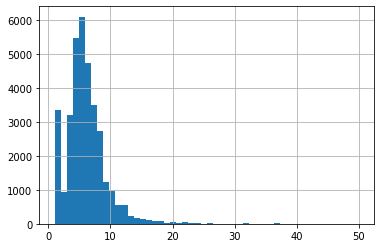

In [38]:
X['number_of_photos'].hist(bins=50, figsize=(6,4))
plt.show()

Длинный хвост - прологарифмируем

In [39]:
X['number_of_photos']=np.log(X['number_of_photos'])
X_test['number_of_photos']=np.log(X_test['number_of_photos'])

In [40]:
X = X.drop(columns=['photos'])
X_test = X_test.drop(columns=['photos'])

**Опираясь на житейский опыт, можно сказать, что каждый район имеет разные цены на жилье. Значит мы можем сгруппировать наши building_id по "районам" согласно их цене за комнату**

In [41]:
len(X['building_id'].value_counts())

6331

Всего 6331 уникальных значений building_id

Разделим здания на:
* здания с низкой ценой
* здания c средне-низкой ценой
* здания c средней ценой
* здания c высокой ценой

In [42]:
X_old = X.copy()

In [43]:
mean = X.groupby('building_id').mean()['cost_of_one_room']
cluster = pd.concat([mean], axis = 1)
cluster['building_id'] = cluster.index
cluster.columns = ['cost_of_one_room', 'building_id']
cluster.describe()

,cost_of_one_room
count,6.331000e+03
mean,1.726599e+03
std,2.054762e+04
min,4.500000e+01
25%,8.750000e+02
50%,1.175000e+03
75%,1.625000e+03
max,1.496667e+06


In [44]:
cluster1 = cluster[cluster.cost_of_one_room < 875] #здания с низкой ценой
cluster2 = cluster[(cluster.cost_of_one_room >= 875) & (cluster.cost_of_one_room < 1175)] #здания c средне-низкой ценой
cluster3 = cluster[(cluster.cost_of_one_room >= 1175) & (cluster.cost_of_one_room < 1625)] #здания c средней ценой
cluster4 = cluster[cluster.cost_of_one_room >= 1625] #здания c высокой ценой

In [45]:
def get_group(x):
    if x in cluster1.index:
        return 'low_price'
    elif x in cluster2.index:
        return 'medium-low_price'
    elif x in cluster3.index:
        return 'medium_price'
    else:
        return 'high_price'

X['group'] = X.building_id.apply(get_group)

для X_test аналогично

In [46]:
X_test_old = X_test.copy()

mean = X_test.groupby('building_id').mean()['cost_of_one_room']
cluster = pd.concat([mean], axis = 1)
cluster['building_id'] = cluster.index
cluster.columns = ['cost_of_one_room', 'building_id']
cluster.describe()

,cost_of_one_room
count,4049.000000
mean,1417.223212
std,2176.964231
min,43.000000
25%,916.666667
50%,1221.111111
75%,1700.000000
max,111111.000000


In [47]:
cluster1 = cluster[cluster.cost_of_one_room < 916] #здания с низкой ценой
cluster2 = cluster[(cluster.cost_of_one_room >= 916) & (cluster.cost_of_one_room < 1221)] #здания c средне-низкой ценой
cluster3 = cluster[(cluster.cost_of_one_room >= 1221) & (cluster.cost_of_one_room < 1700)] #здания c средней ценой
cluster4 = cluster[cluster.cost_of_one_room >= 1700] #здания c высокой ценой

In [48]:
X_test['group'] = X_test.building_id.apply(get_group)

In [49]:
X = X.drop(columns=['building_id'])
X_test = X_test.drop(columns=['building_id'])

**Посмотрим на признаки, которые мы имеем**

In [50]:
X.head()

,bathrooms,bedrooms,created,latitude,longitude,price,TARGET,postcode,no/reduced_fee,elevator,...,park/terrace/garden,internet,cost_of_one_room,month_year_cnt,week_year_cnt,month,day_of_week,hour,number_of_photos,group
0,1.0,3,2016-05-19 18:06:27,40.7647,-73.9918,4495,medium,10019.0,1.0,1.0,...,0.0,0.0,1123.750000,11072,2938,5,3,18,1.098612,medium_price
1,1.0,1,2016-06-16 02:01:49,40.7275,-74.0322,2570,medium,7310.0,1.0,0.0,...,0.0,0.0,1285.000000,12033,2336,6,3,2,2.564949,medium_price
2,1.0,0,2016-05-04 02:42:50,40.7798,-73.9751,1795,low,10023.0,0.0,1.0,...,0.0,0.0,1795.000000,11072,2843,5,2,2,1.791759,high_price
3,1.0,2,2016-05-12 05:57:56,40.7081,-74.0065,3400,low,10038.0,1.0,1.0,...,0.0,0.0,1133.333333,11072,2850,5,3,5,1.386294,medium_price
4,1.0,3,2016-06-16 06:06:15,40.7416,-74.0025,5695,low,10011.0,0.0,0.0,...,0.0,0.0,1423.750000,12033,2336,6,3,6,1.098612,medium_price


In [51]:
X.columns

Index(['bathrooms', 'bedrooms', 'created', 'latitude', 'longitude', 'price',
       'TARGET', 'postcode', 'no/reduced_fee', 'elevator', 'pets', 'laundry',
       'hardwood_floors', 'doorman', 'furniture', 'pre-war_building', 'sport',
       'park/terrace/garden', 'internet', 'cost_of_one_room', 'month_year_cnt',
       'week_year_cnt', 'month', 'day_of_week', 'hour', 'number_of_photos',
       'group'],
      dtype='object')

In [52]:
X_test.columns

Index(['Id', 'bathrooms', 'bedrooms', 'created', 'latitude', 'longitude',
       'price', 'no/reduced_fee', 'elevator', 'pets', 'laundry',
       'hardwood_floors', 'doorman', 'furniture', 'pre-war_building', 'sport',
       'park/terrace/garden', 'internet', 'cost_of_one_room', 'month_year_cnt',
       'week_year_cnt', 'month', 'day_of_week', 'hour', 'number_of_photos',
       'group'],
      dtype='object')

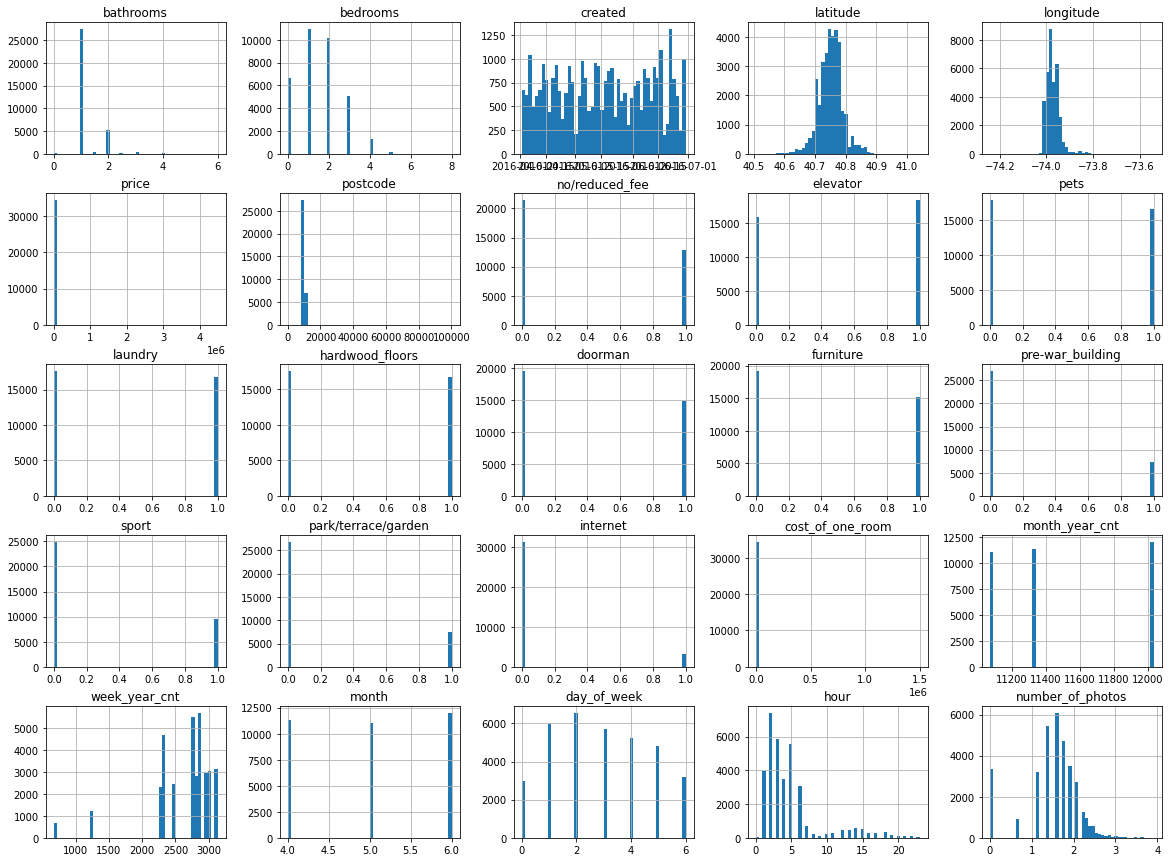

In [53]:
X.hist(bins=50, figsize=(20,15))
plt.show()

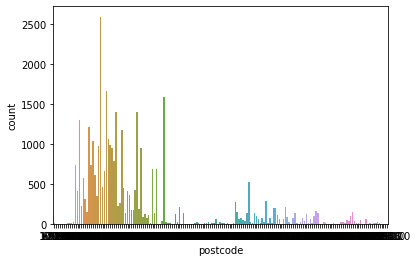

In [54]:
plt.rcParams["figure.figsize"] = (6, 4)
sns.countplot(x='postcode', data=X)

у postcode и hour тоже длинный хвост - прологарифмируем

In [55]:
X['postcode']=np.log(X['postcode'])

In [56]:
hour_tmp  = np.where(X['hour'] > 1.0e-10, X['hour'], 1.0e-10)
X['hour'] = np.where(X['hour'] > 1.0e-10, np.log10(hour_tmp), -10)

hour_tmp  = np.where(X_test['hour'] > 1.0e-10, X_test['hour'], 1.0e-10)
X_test['hour'] = np.where(X_test['hour'] > 1.0e-10, np.log10(hour_tmp), -10)

In [57]:
X['price']=np.log(X['price'])
X_test['price']=np.log(X_test['price'])

X['cost_of_one_room']=np.log(X['cost_of_one_room'])
X_test['cost_of_one_room']=np.log(X_test['cost_of_one_room'])

# Train and Build a Model

In [58]:
X.columns

Index(['bathrooms', 'bedrooms', 'created', 'latitude', 'longitude', 'price',
       'TARGET', 'postcode', 'no/reduced_fee', 'elevator', 'pets', 'laundry',
       'hardwood_floors', 'doorman', 'furniture', 'pre-war_building', 'sport',
       'park/terrace/garden', 'internet', 'cost_of_one_room', 'month_year_cnt',
       'week_year_cnt', 'month', 'day_of_week', 'hour', 'number_of_photos',
       'group'],
      dtype='object')

In [59]:
Counter(X['TARGET'])

Counter({'high': 2672, 'low': 23933, 'medium': 7838})

Видим, что классы у нас очень несбалансированны

Разделим выборку на X_train, y_train, X_test, y_test и закодируем категориальные признаки

In [60]:
target_nums = {"TARGET": {"low": 1, "medium": 2, "high": 3}}
X = X.replace(target_nums)
X['TARGET']

0        2
1        2
2        1
3        1
4        1
        ..
34438    1
34439    2
34440    1
34441    2
34442    2
Name: TARGET, Length: 34443, dtype: int64

In [61]:
X_train = pd.get_dummies(X, columns = ['group'])
X_train = X_train.drop(columns = ['TARGET'])

y_train = X['TARGET']

X_test = pd.get_dummies(X_test, columns = ['group'])
target_nums = {"Id": {"low": 1, "medium": 2, "high": 3}}
X_test = X_test.replace(target_nums)

y_test = X_test['Id']
X_test = X_test.drop(columns = ['Id'])

In [62]:
X_train = X_train.drop(columns = ['created'])
X_test = X_test.drop(columns = ['created'])

In [63]:
import time
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

К сожалению, я не успела получить признак postcode для X_test (хотя, возможно, он мог бы пригодиться), поэтому уберём его из тренировочной выборки

In [64]:
X_train = X_train.drop(columns = ['postcode'])

**1 метод. Для отбора признаков используем L1 регуляризацию с логистической регрессией**

In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel

pipe = make_pipeline(SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')), LogisticRegression())
print(cross_val_score(pipe, X_train, y_train, scoring='accuracy').mean())

0.7046422961481964


In [66]:
pipe.fit(X_train, y_train)

y_pred_log_reg = pipe.predict(X_test)
print('accuracy на тесте:', accuracy_score(y_test, y_pred_log_reg))

accuracy на тесте: 0.6980278265568013


**2 метод. Выберем лучшие признаки с помощью скоринговой функции для классификации f_classif в методе ANOVA**

In [67]:
from sklearn.feature_selection import SelectKBest, f_classif

def fclassif(X, y):
  scores = {}

  for i in range(2, 28):
    print('k =', i)
    x_data_kbest = SelectKBest(f_classif, k=i).fit_transform(X, y)

    start_time = datetime.datetime.now()
    score = cross_val_score(LogisticRegression(), x_data_kbest, y, scoring='accuracy', n_jobs=-1).mean()
    print('Score:', score)
    print('Time elapsed:', datetime.datetime.now() - start_time)

    scores[i] = score
    print()
  
  return scores

def find_best_k(scores):
  scores = pd.Series(scores)
  best_k = (scores.sort_values(ascending=False).head(1)).index[0]
  best_score = (scores.sort_values(ascending=False).head(1)).values[0]
  print('Лучшее количество признаков равно k =', best_k, ', при котором качество равно', best_score)

k = 2
Score: 0.6978775982988247
Time elapsed: 0:00:02.015439

k = 3
Score: 0.6989809032528249
Time elapsed: 0:00:00.611332

k = 4
Score: 0.6973840410127138
Time elapsed: 0:00:00.756950

k = 5
Score: 0.6969195113015768
Time elapsed: 0:00:00.755941

k = 6
Score: 0.7010423331375963
Time elapsed: 0:00:00.778418

k = 7
Score: 0.7012745958857469
Time elapsed: 0:00:00.862085

k = 8
Score: 0.7017390876633607
Time elapsed: 0:00:00.987078

k = 9
Score: 0.7002873506536116
Time elapsed: 0:00:00.963743

k = 10
Score: 0.6998518948806435
Time elapsed: 0:00:01.043364

k = 11
Score: 0.6998518948806435
Time elapsed: 0:00:01.068305

k = 12
Score: 0.7033649901229535
Time elapsed: 0:00:01.192337

k = 13
Score: 0.7036262720164062
Time elapsed: 0:00:01.220851

k = 14
Score: 0.7035391766469766
Time elapsed: 0:00:01.353364

k = 15
Score: 0.7055715073045635
Time elapsed: 0:00:01.499376

k = 16
Score: 0.7055424333663944
Time elapsed: 0:00:01.454535

k = 17
Score: 0.7063264097066659
Time elapsed: 0:00:01.450217



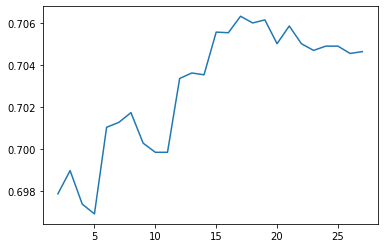


Лучшее количество признаков равно k = 17 , при котором качество равно 0.7063264097066659


In [68]:
scores = fclassif(X_train, y_train)
pd.Series(scores).plot()
plt.show()
print()
find_best_k(scores)

In [69]:
x_data_kbest = SelectKBest(f_classif, k = 17).fit(X_train, y_train)

X2_train = x_data_kbest.transform(X_train)
X2_test = x_data_kbest.transform(X_test)

In [70]:
lr = LogisticRegression()
lr.fit(X2_train, y_train)

y_pred = lr.predict(X2_test)
print('accuracy на тесте:', accuracy_score(y_test, y_pred))

accuracy на тесте: 0.6999189517763069


**3 метод. Выберем признаки по граничному значению дисперсии данных**

In [71]:
from sklearn.feature_selection import VarianceThreshold

x_data_varth = VarianceThreshold(.9).fit_transform(X_train)
cross_val_score(LogisticRegression(), x_data_varth, y_train, scoring='accuracy').mean()

0.7046422961481964

In [72]:
x_data_varth = VarianceThreshold(.9)
x_data_varth.fit_transform(X_train)

X2_train = x_data_varth.transform(X_train)
X2_test = x_data_varth.transform(X_test)

lr = LogisticRegression()
lr.fit(X2_train, y_train)

y_pred = lr.predict(X2_test)
print('accuracy на тесте:', accuracy_score(y_test, y_pred))

accuracy на тесте: 0.6980278265568013


Итак:

лучший accuracy на тесте, равный **0.6999189517763069**, получился при использовании скоринговой функции для классификации f_classif в методе ANOVA

In [73]:
x_data_kbest = SelectKBest(f_classif, k = 17).fit(X_train, y_train)

X2_train = x_data_kbest.transform(X_train)
X2_test = x_data_kbest.transform(X_test)

lr = LogisticRegression()
lr.fit(X2_train, y_train)

y_pred = lr.predict(X2_test)
print('accuracy на тесте:', accuracy_score(y_test, y_pred))

accuracy на тесте: 0.6999189517763069


In [74]:
def log_reg(X, y):
  scores = {}

  for i in range(-5, 6):
    c = 10.0 ** i
    print('С=', c)
    clf = LogisticRegression(C=c, random_state=42)

    start_time = datetime.datetime.now()
    score = cross_val_score(clf, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()
    print('Score:', score)
    print('Time elapsed:', datetime.datetime.now() - start_time)

    scores[i] = score
    print()
  
  return scores

def find_best_c(scores):
  scores = pd.Series(scores)
  best_c = 10.0 ** (scores.sort_values(ascending=False).head(1)).index[0]
  best_score = (scores.sort_values(ascending=False).head(1)).values[0]
  print('Лучший параметр регуляризации равен С =', best_c, ', при котором качество равно', best_score)

С= 1e-05
Score: 0.69485814885418
Time elapsed: 0:00:01.018269

С= 0.0001
Score: 0.6965711129645149
Time elapsed: 0:00:00.723869

С= 0.001
Score: 0.7018262420404932
Time elapsed: 0:00:01.067618

С= 0.01
Score: 0.7073424886313231
Time elapsed: 0:00:01.397224

С= 0.1
Score: 0.707110204808993
Time elapsed: 0:00:01.488814

С= 1.0
Score: 0.7070811645895112
Time elapsed: 0:00:01.531035

С= 10.0
Score: 0.707110196379321
Time elapsed: 0:00:01.481881

С= 100.0
Score: 0.707110196379321
Time elapsed: 0:00:01.492999

С= 1000.0
Score: 0.707110196379321
Time elapsed: 0:00:01.482423

С= 10000.0
Score: 0.707110196379321
Time elapsed: 0:00:01.510126

С= 100000.0
Score: 0.707110196379321
Time elapsed: 0:00:01.499158



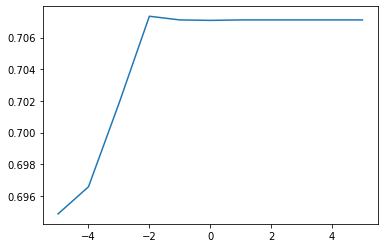


Лучший параметр регуляризации равен С = 0.01 , при котором качество равно 0.7073424886313231


In [75]:
scores = log_reg(X2_train, y_train)
pd.Series(scores).plot()
plt.show()
print()
find_best_c(scores)

In [76]:
clf = LogisticRegression(C=0.01, random_state=42)
clf.fit(X2_train, y_train)

score = cross_val_score(clf, X2_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1).mean()
print('Score:', score)

Score: 0.7073424886313231


In [77]:
y_pred_log_reg = clf.predict(X2_test)
print(accuracy_score(y_test, y_pred_log_reg))

0.6999189517763069


aaccuracy не изменилась, значит будем считать это лучшим результатом